<a href="https://colab.research.google.com/github/PTC-Education/PTC-API-Playground/blob/main/Strandbeest_Motion_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import and Setup Onshape Client

!pip install onshape-client
from onshape_client.client import Client
from onshape_client.onshape_url import OnshapeElement
import json

#@markdown Chage the base if using an enterprise (i.e. "https://ptc.onshape.com")
base = 'https://cad.onshape.com' #@param {type:"string"}

#@markdown Would you like to import your API keys from a file, or copy and paste them directly?
keyImportOption = "Upload Keys from File" #@param ["Upload Keys from File", "Copy/Paste Keys"]

from IPython.display import clear_output 
clear_output()
print("Onshape Client successfully imported!")

if keyImportOption == "Upload Keys from File":
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    execfile(fn)

  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')
else:
  access = input("Paste your Onshape Access Key: ")
  secret = input("Paste your Onshape Secret Key: ")
  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')


Onshape client configured - ready to go!


In [4]:
#@title Get Variables from Part Studio
#@markdown Defines function `getVariables(url, config)`, which returns JSON of mass properties for all parts in a part studio

url = 'https://cad.onshape.com/documents/79b9a166322a0e05c853484b/w/a5f8c25aa1e6a08197ed6c88/e/e3a6884c7b5f8af40e0ca5f9' #@param {type:"string"}
config = '' #@param {type:"string"}

#@markdown **Also defines** function `getVariableValue(url,config,varName)`

#@markdown Input a variable name to get value for that variable.
varName = 'xPos' #@param {type:"string"}

# USING (MODIFIED) CODE FROM https://github.com/onshape-public/onshape-clients/blob/master/python/test/test_get_variables.py

import json

from onshape_client.oas import BTFeatureScriptEvalCall2377
from onshape_client.onshape_url import OnshapeElement
from onshape_client.utility import parse_quantity

script = r'''
    function(context, queries) {
            return getAllVariables(context);
        }
    '''
def getVariables(url, config):
    element = OnshapeElement(url)
    script_call = BTFeatureScriptEvalCall2377(script=script)
    response = client.part_studios_api.eval_feature_script(
        element.did,
        element.wvm,
        element.wvmid,
        element.eid,
        bt_feature_script_eval_call_2377=script_call,
        _preload_content=False,
        configuration=config
    )
    measurements = json.loads(response.data.decode("utf-8"))["result"]["message"]["value"]
    parsed_measurements = parse_variables_from_map(measurements)  
    vars = []
    for name, val in parsed_measurements.items():
        vars.append({name:val})
    return vars

def parse_variables_from_map(unparsed):
    parsed_variables = {}
    value = None
    for to_parse in unparsed:
        if is_fs_type(to_parse, "BTFSValueMapEntry"):
            key = to_parse["message"]["key"]["message"]["value"]
            candidate_message = to_parse["message"]["value"]
            if is_fs_type(candidate_message, ["BTFSValueMap", "BTFSValueArray"]):
                value = parse_variables_from_map(candidate_message["message"]["value"])
            elif is_fs_type(candidate_message, "BTFSValueWithUnits"):
                value = parse_quantity(candidate_message["message"])
            parsed_variables[key] = value
    return parsed_variables

def is_fs_type(candidate, type_name):
    result = False
    try:
        if isinstance(type_name, str):
            result = type_name == candidate["typeName"]
        elif isinstance(type_name, list):
            result = any(
                [type_name_one == candidate["typeName"] for type_name_one in type_name]
            )
    except Exception:
        result = False
    return result

def getVariableValue(url,config,varName):
  vars = getVariables(url,config)
  for x in vars:
    if varName in x:
      return(x[varName])

print(getVariableValue(url,config,varName))


0.007667423965593264*meter


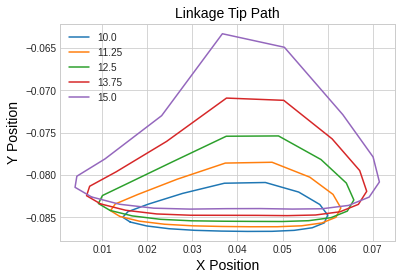

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

plt.style.use('seaborn-whitegrid')
plt.title('Linkage Tip Path', fontdict=font)
plt.xlabel('X Position', fontdict=font)  
plt.ylabel('Y Position', fontdict=font) 

configDef = 'Crank_Length%3D{}%2Bmm%3BRotation%3D{}%2Bradian'

angles = np.linspace(0,6.28,20)
xPos = []
yPos = []

backLegLengths = np.linspace(10,15,5)

for idx, length in enumerate(backLegLengths):
  xPos = []
  yPos = []
  for ang in angles:
    vars = getVariables(url,configDef.format(str(length),str(ang)))
    for var in vars:
      if 'xPos' in var:
        xPos.append(float(var['xPos'].strip("*meters")))
      elif 'yPos' in var:
        yPos.append(-1*float(var['yPos'].strip("*meters")))

  plt.plot(xPos, yPos,label=str(length));

legend = plt.legend()